# Importation Library

In [1]:
###### Library de base
import pandas as pd
from datetime import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gc

###### Librabary Sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV


###### Library LightGBM

import lightgbm as lgb

# Importation de la base

In [9]:
##############
#### Importation de toute la base
##############


#train=pd.read_csv("train.csv",sep=",")
weather_train=pd.read_csv("weather_train.csv",sep=",")
building_meta=pd.read_csv("building_metadata.csv",sep=',')

In [13]:
##############
####  Importation d'un Pourcentage de la base
##############

random.seed(30)
# On selectionne 20% des lignes de la bases pour tester les modèles
p = 0.1  # 20% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
train = pd.read_csv(
         "train.csv",sep=",",
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

# Definition de fonction

In [4]:
##############
#### Fonction pour réduire la taille de la base
##############


def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Source : https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

In [5]:
##############
#### Fonction pour calculer les données manquantes
##############



def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

# Source : https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling

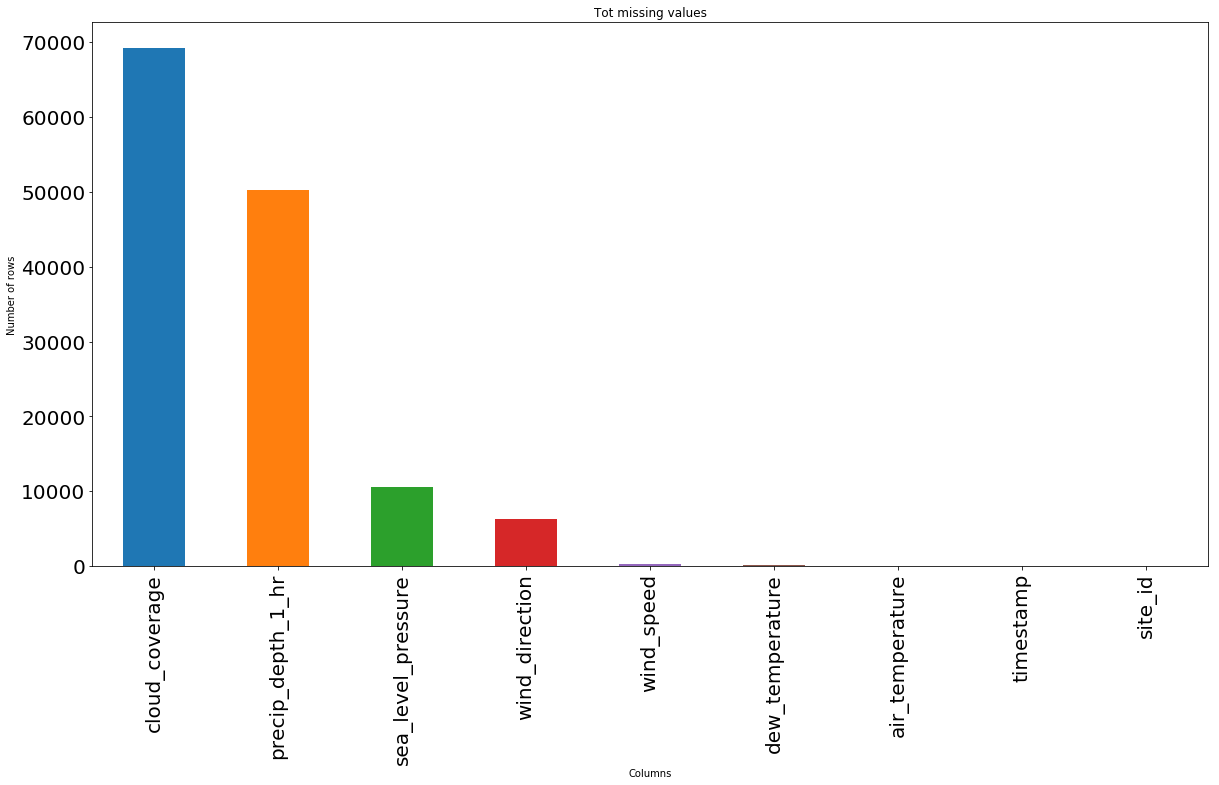

In [8]:
##############
#### Visualisation des valeurs manquantes
##############

def val_manq(df):
    percent = (df.isnull().sum()).sort_values(ascending=False)
    percent.plot(kind='bar', figsize = (20,10), fontsize=20)
    plt.xlabel('Columns')
    plt.ylabel('Number of rows')
    plt.title('Tot missing values')
val_manq(weather_train)

# Remplissage des données manquantes

In [5]:
print("Date du début de l'étude : "+ min(train["timestamp"]))
print("Date de la fin de l'étude : "+max(train["timestamp"]))

Date du début de l'étude : 2016-01-01 00:00:00
Date de la fin de l'étude : 2016-12-31 23:00:00


In [11]:
##############
#### En comparant le nombre d'heure en 2016 et le nombre d'heure dans 
#### la base weather on comprend bien qu'il y a un pb.
##############


print("Nombre d'heures dans l'année 2016 : " + str(366*24)) 
print("Nombre d'heures pour chaque site dans l'année 2016 : " + str(366*24*16)) 
print("Nombre d'heures dans la base weather : " + str(len(weather_train["timestamp"])))

Nombre d'heures dans l'année 2016 : 8784
Nombre d'heures pour chaque site dans l'année 2016 : 140544
Nombre d'heures dans la base weather : 139773


Normalement la base de données weather_train à autant de données que d'heures dans l'années 2016 multiplié par le nombre de lieu où des mesures ont été effectués, c'est à dire le nombre de site_id différents. Cependant en faisant les calculs nous nous sommes rendus compte qu'il manquait environ 1000 heures mesurés, 139773 lignes dans la base weather_train alors qu'il devrait en avoir 140544. Nous avons décidés de rajouter ses lignes manquantes.

In [7]:
##############
#### Problème de date manquante
##############

format_date = "%Y-%m-%d %H:%M:%S"

date_deb = min(weather_train["timestamp"])
date_fin = max(weather_train["timestamp"])

diff = 366*24 # Nombres d'heures pendant toute la durée de l'étude

début = datetime.datetime.strptime(date_deb,format_date)
# date time de la valeur de départ de l'étude
fin = datetime.datetime.strptime(date_fin,format_date)
# date time de la valeur de fin de l'étude

date_list = [(début + datetime.timedelta(hours=x)).strftime(format_date) for x in range(diff)]
# Création d'une liste de date sous le format timestamp

for i in range(0,16):
    heure_site = weather_train[weather_train["site_id"]==i]["timestamp"]
    heure_site = heure_site.values.tolist()
    heure_manquante = list(set(date_list)-set(heure_site))
    rangs_manquants = pd.DataFrame({'timestamp' : heure_manquante,'site_id' : i})
    weather_train = pd.concat([rangs_manquants,weather_train],sort=False)
# Créations des lignes manquantes de la base


In [12]:
##############
#### Pourcentage de données manquantes
##############


print(missing_statistics(train))
print(missing_statistics(weather_train))
print(missing_statistics(building_meta))

     COLUMN NAME  MISSING VALUES  TOTAL ROWS  % MISSING
0    building_id               0    20216100        0.0
1          meter               0    20216100        0.0
2      timestamp               0    20216100        0.0
3  meter_reading               0    20216100        0.0
          COLUMN NAME  MISSING VALUES  TOTAL ROWS  % MISSING
0             site_id               0      139773       0.00
1           timestamp               0      139773       0.00
2     air_temperature              55      139773       0.04
3      cloud_coverage           69173      139773      49.49
4     dew_temperature             113      139773       0.08
5   precip_depth_1_hr           50289      139773      35.98
6  sea_level_pressure           10618      139773       7.60
7      wind_direction            6268      139773       4.48
8          wind_speed             304      139773       0.22
   COLUMN NAME  MISSING VALUES  TOTAL ROWS  % MISSING
0      site_id               0        1449       0.00
1 

In [31]:
##############
#### Création de nouvelles colonnes
##############

weather_train["datetime"] = pd.to_datetime(weather_train["timestamp"])
weather_train["annee"] = weather_train["datetime"].dt.year
weather_train["mois"] = weather_train["datetime"].dt.month
weather_train["semaine"] = weather_train["datetime"].dt.week
weather_train["jour"] = weather_train["datetime"].dt.day
weather_train["heure"] = weather_train["datetime"].dt.hour
weather_train.drop(columns=["datetime"],inplace=True)


##############
#### Remplisssage des données manquantes de la base weather par des moyennes
##############


col_weather=["air_temperature","cloud_coverage","dew_temperature","precip_depth_1_hr","sea_level_pressure","wind_direction","wind_speed"]
mean_weather=weather_train.groupby(["site_id","mois"]).transform(lambda x: x.fillna(x.mean()))
for col in col_weather:
    weather_train[col] = mean_weather[col]
weather_train=weather_train.fillna(method='ffill')
building_meta.drop(columns=["year_built","floor_count"],inplace=True)
# Les variables year_built et floor count sont enlevés de la base car elles ont 
# trop de valeurs manquantes qui ne peuvent pas être approximée

# Manipulation de la base

In [14]:
##############
#### Encoding d'une variables qualitative
##############
#A faire après les graphiques

labelencoder=LabelEncoder()
building_meta["primary_use"] = labelencoder.fit_transform(building_meta["primary_use"])

In [15]:
##############
#### Merge des 3 bases
##############



df=pd.merge(train,building_meta, left_on='building_id', right_on='building_id')
df=pd.merge(df,weather_train, on=['timestamp','site_id'])
df = reduce_mem_usage(df)


Mem. usage decreased to 90.33 Mb (64.4% reduction)


In [16]:
##############
#### Conversion d'unité d'un certain type de meter à un certain endroit
##############

df.loc[(df["site_id"] == 0) & (df["meter"] == 0), "meter_reading"]=df.loc[(df["site_id"] == 0) & (df["meter"] == 0), "meter_reading"]*0.2931

In [17]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2,0,2016-01-01 00:00:00,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,13,0,2016-01-01 00:00:00,0.0,0,0,99380,2000.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,21,0,2016-01-01 00:00:00,0.0,0,6,7043,1990.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,22,0,2016-01-01 00:00:00,0.0,0,0,3569,1996.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,37,0,2016-01-01 00:00:00,0.0,0,4,53130,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


# Data Vizualisation

In [14]:
print(min(df["timestamp"]))
print(max(df["timestamp"]))

2016-01-01 00:00:00
2016-12-31 23:00:00


In [15]:
##############
#### Description de la base
##############


df.describe()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,annee,mois,semaine,jour,heure
count,202234.000000,202234.000000,2.022340e+05,202234.000000,202234.000000,202234.000000,202234.000000,202234.000000,202234.000000,202234.0,202234.0,202234.0,202234.000000,202234.0,202234.000000,202234.000000,202234.000000,202234.000000
mean,796.358599,0.660878,2.428175e+03,7.958029,3.154074,107418.367475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0,6.595355,26.989319,15.766834,11.517514
std,426.539076,0.930582,1.749271e+05,5.092929,3.446868,116287.831206,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.0,3.437106,15.035669,8.829206,6.931238
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,283.000000,-28.796875,0.000000,-35.000000,-1.0,970.0,0.0,0.000000,2016.0,1.000000,1.000000,1.000000,0.000000
25%,388.000000,0.000000,1.800000e+01,3.000000,0.000000,32527.000000,8.500000,0.000000,0.099976,0.0,1012.0,80.0,2.099609,2016.0,4.000000,14.000000,8.000000,5.000000
50%,893.000000,0.000000,7.481689e+01,9.000000,1.000000,72332.000000,16.703125,1.139648,8.898438,0.0,1016.0,170.0,3.099609,2016.0,7.000000,27.000000,16.000000,12.000000
75%,1176.000000,1.000000,2.502995e+02,13.000000,6.000000,138977.000000,24.406250,3.027344,16.093750,0.0,1020.0,270.0,4.601562,2016.0,10.000000,40.000000,23.000000,18.000000
max,1448.000000,3.000000,2.116270e+07,15.000000,15.000000,875000.000000,47.187500,9.000000,26.093750,343.0,1046.0,360.0,18.000000,2016.0,12.000000,53.000000,31.000000,23.000000


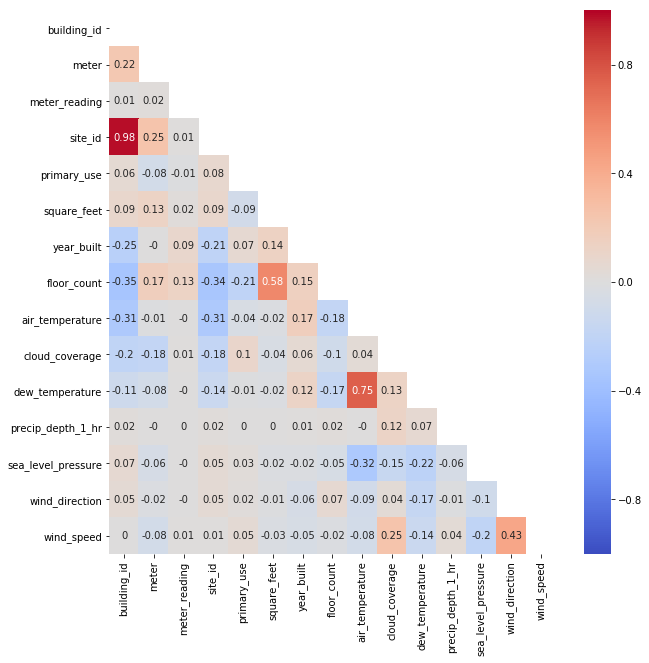

In [18]:
corr= df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr.round(2), mask=mask,
            vmin=-1,     
            cmap='coolwarm',
            annot=True)

Nos variables sont faiblements corrélés avec comme exceptions les variables site_id et building_id avec une corrélation de 0.98, les variables drew_temperature et air_temperature avec une corrélation de 0.75 et les variables mois et semaine avec une corrélation de 0.95. Ces corrélations fortes étant données que ses variables dépendent les unes des autres.

In [37]:
##############
#### Calcul des consommations moyennes de chaques meter type par semaine
##############

moyenne_conso_semaine = df.groupby(['semaine']).mean()
moyenne_conso_semaine_0 = df[df["meter"]==0].groupby(['semaine']).mean()
moyenne_conso_semaine_1 = df[df["meter"]==1].groupby(['semaine']).mean()
moyenne_conso_semaine_2 = df[df["meter"]==2].groupby(['semaine']).mean()
moyenne_conso_semaine_3 = df[df["meter"]==3].groupby(['semaine']).mean()

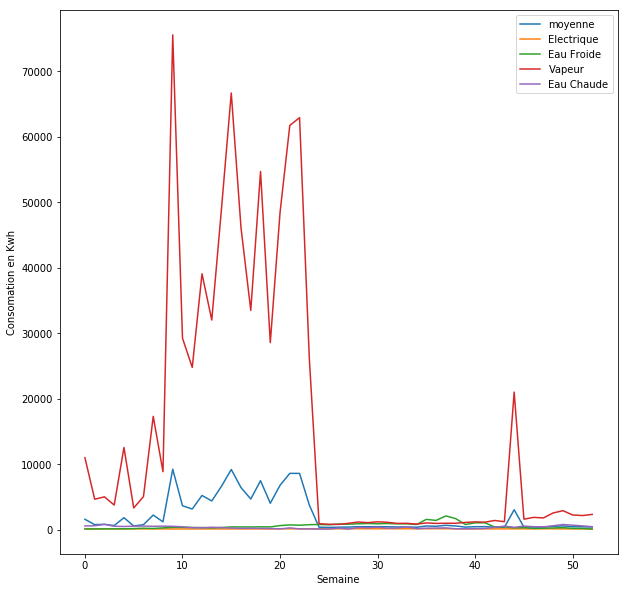

In [39]:
##############
#### Plot Standard
##############


plt.figure(figsize=(10,10))
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine["meter_reading"],label='Moyenne')
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine_0["meter_reading"],label='Electrique')
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine_1["meter_reading"],label='Eau Froide')
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine_2["meter_reading"],label='Vapeur')
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine_3["meter_reading"],label='Eau Chaude')
plt.ylabel('Consomation en Kwh')
plt.xlabel('Semaine')
plt.legend()

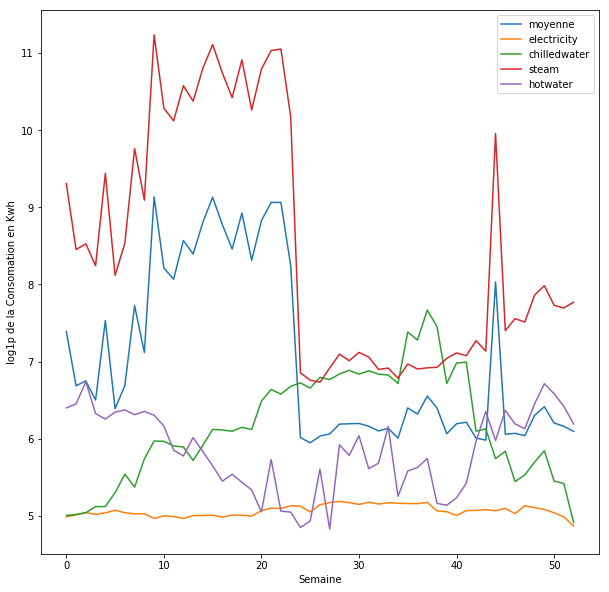

In [40]:
##############
#### Plot Log de la valeur
##############



plt.figure(figsize=(10,10))
plt.plot(range(0,len(moyenne_conso_semaine)),np.log1p(moyenne_conso_semaine["meter_reading"]),label='moyenne')
plt.plot(range(0,len(moyenne_conso_semaine)),np.log1p(moyenne_conso_semaine_0["meter_reading"]),label='electricity')
plt.plot(range(0,len(moyenne_conso_semaine)),np.log1p(moyenne_conso_semaine_1["meter_reading"]),label='chilledwater')
plt.plot(range(0,len(moyenne_conso_semaine)),np.log1p(moyenne_conso_semaine_2["meter_reading"]),label='steam')
plt.plot(range(0,len(moyenne_conso_semaine)),np.log1p(moyenne_conso_semaine_3["meter_reading"]),label='hotwater')
plt.ylabel('log1p de la Consomation en Kwh')
plt.xlabel('Semaine')
plt.legend()


del moyenne_conso_semaine
del moyenne_conso_semaine_0
del moyenne_conso_semaine_1
del moyenne_conso_semaine_2
del moyenne_conso_semaine_3

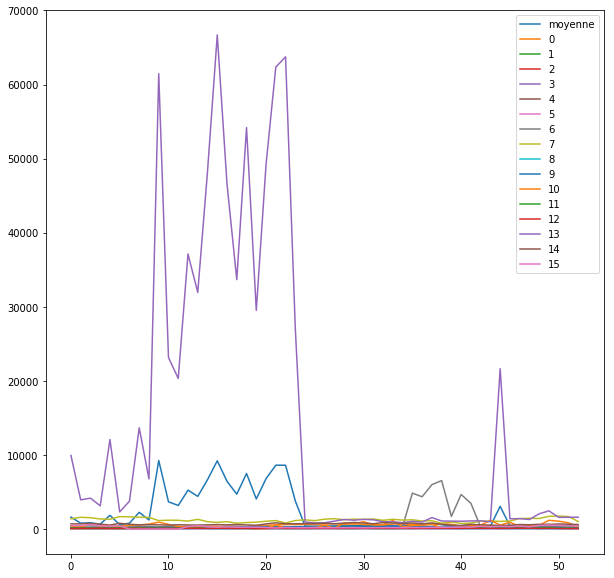

In [41]:
##############
#### Calcul des consommations moyennes chaque site par semaine
##############

moyenne_conso_semaine = df.groupby(['semaine']).mean()

plt.figure(figsize=(10,10))
plt.plot(range(0,len(moyenne_conso_semaine)),moyenne_conso_semaine["meter_reading"],label='moyenne')

for i,k in enumerate (df["site_id"].unique()):
    moyenne_conso_site= df[df["site_id"]==i].groupby(['semaine']).mean()
    plt.plot(range(0,len(moyenne_conso_site)),moyenne_conso_site["meter_reading"],label=i)
    
plt.legend()


###### Un site semble se détaché sur reste, nous passons à plot des valeurs en log pour voir plus en détails



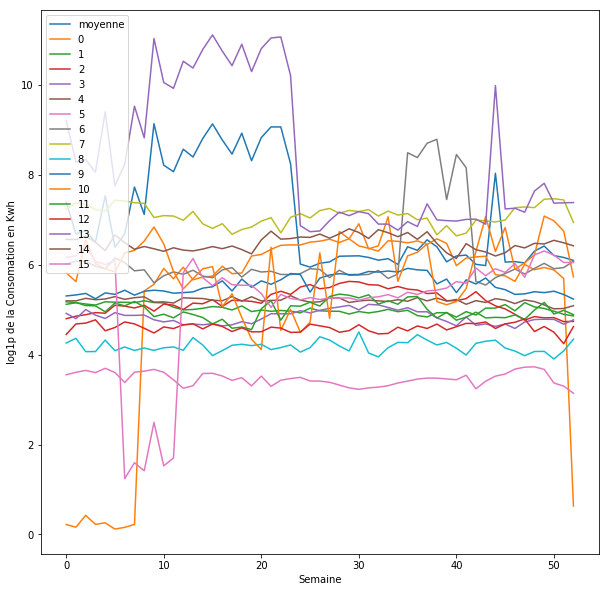

In [42]:
##############
#### Calcul des consommations moyennes de chaques site par semaine version log
##############

moyenne_conso_semaine = df.groupby(['semaine']).mean()

plt.figure(figsize=(10,10))
plt.plot(range(0,len(moyenne_conso_semaine)),np.log(moyenne_conso_semaine["meter_reading"]),label='moyenne')

for i,k in enumerate (df["site_id"].unique()):
    moyenne_conso_site= df[df["site_id"]==i].groupby(['semaine']).mean()
    plt.plot(range(0,len(moyenne_conso_site)),np.log1p(moyenne_conso_site["meter_reading"]),label=i)

    
plt.ylabel('log1p de la Consomation en Kwh')
plt.xlabel('Semaine')
plt.legend()


###### Le plot n'est pas beaucoup plus clair


del moyenne_conso_semaine
del moyenne_conso_site

Text(0.5,0,'Taille des batiments en pied carré')

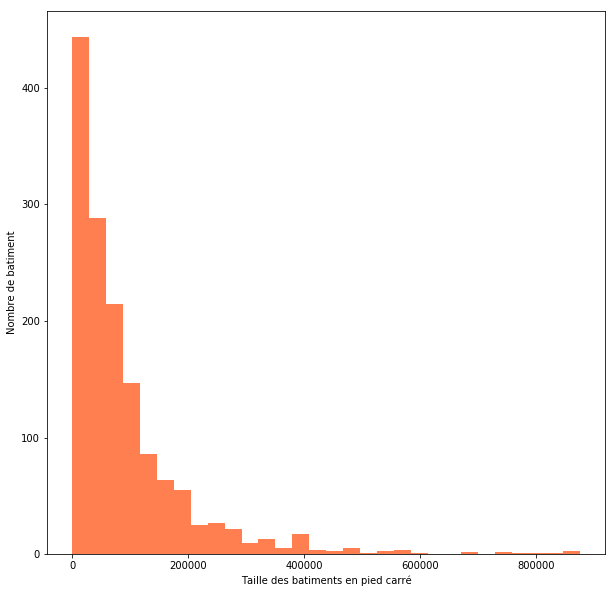

In [22]:
##############
#### Calcul des consommations moyennes de chaques site par semaine version log
##############


plt.figure(figsize=(10,10))
plt.hist(building_meta["square_feet"],bins=30,color='coral')
plt.ylabel('Nombre de batiment')
plt.xlabel('Taille des batiments en pied carré')

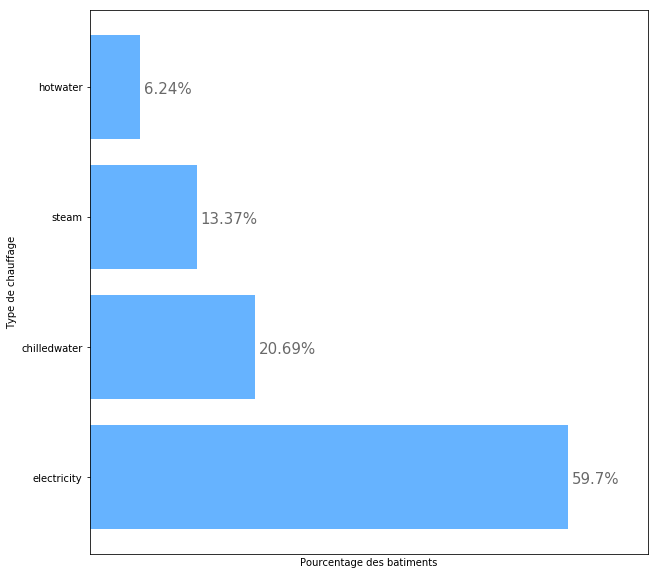

In [23]:
##############
#### Pourcentage de chaque type de consomation
##############


meter_type=train["meter"].value_counts()
meter_type_perc=meter_type*100/sum(meter_type)
nom=['electricity','chilledwater','steam', 'hotwater']
y_position=[0,1,2,3]
plt.figure(figsize=(10,10))
A=plt.barh(y_position,meter_type_perc,
       color='#66b3ff', align="center")
plt.yticks(y_position,nom)

for k in range(len(meter_type)):
    plt.text(meter_type_perc[k]+0.5,
             y_position[k]-0.05, 
             str(round(meter_type_perc[k],2))+'%', 
             fontsize=15,
             color='dimgrey')
    
plt.xlim([0, max(meter_type_perc)+10])
# Enléve l'échelle de l'axe x
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Pourcentage des batiments")
plt.ylabel('Type de chauffage')
plt.show()


del meter_type
del meter_type_perc

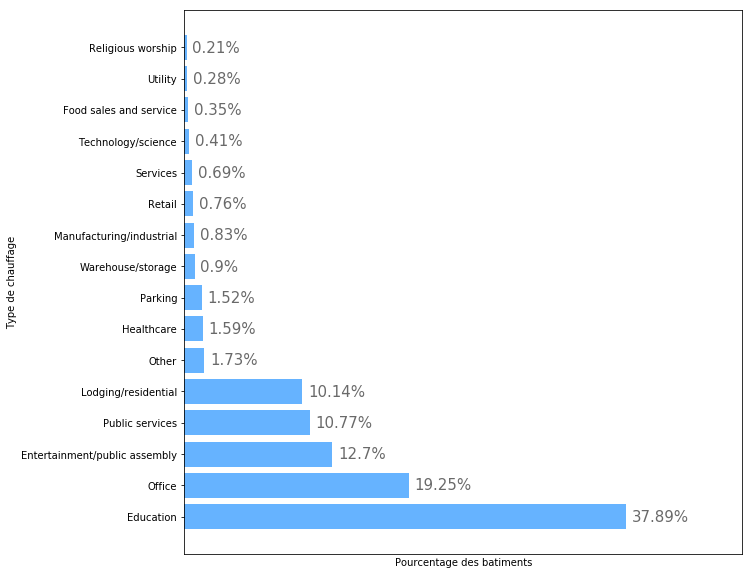

In [24]:
##############
#### Pourcentage d'est utilisation des batiments
##############


primary_use=building_meta["primary_use"].value_counts().reset_index()
primary_use_perc=primary_use["primary_use"]*100/sum(primary_use["primary_use"])
nom=['Education','Office','Entertainment/public assembly' ,'Public services','Lodging/residential' ,'Other' ,'Healthcare','Parking','Warehouse/storage','Manufacturing/industrial','Retail','Services','Technology/science','Food sales and service','Utility','Religious worship']
y_position=range(0,len(primary_use))


plt.figure(figsize=(10,10))
A=plt.barh(y_position,primary_use_perc,
       color='#66b3ff', align="center")
plt.yticks(y_position,nom)

for k in range(len(primary_use_perc)):
    plt.text(primary_use_perc[k]+0.5,
             y_position[k]-0.15, 
             str(round(primary_use_perc[k],2))+'%', 
             fontsize=15,
             color='dimgrey')
    

plt.xlim([0, max(primary_use_perc)+10])
# Enléve l'échelle de l'axe x
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.xlabel("Pourcentage des batiments")
plt.ylabel('Type de chauffage')
plt.show()


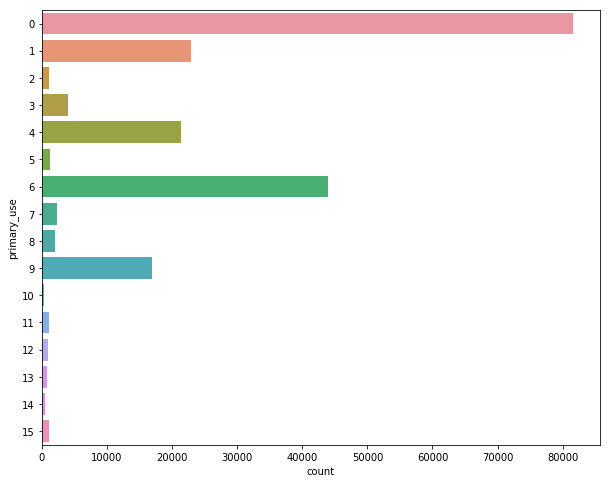

In [25]:
##############
#### Représentation de "indicator of the primary category of activities of the 
#### building"
##############

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(y='primary_use', data=df)

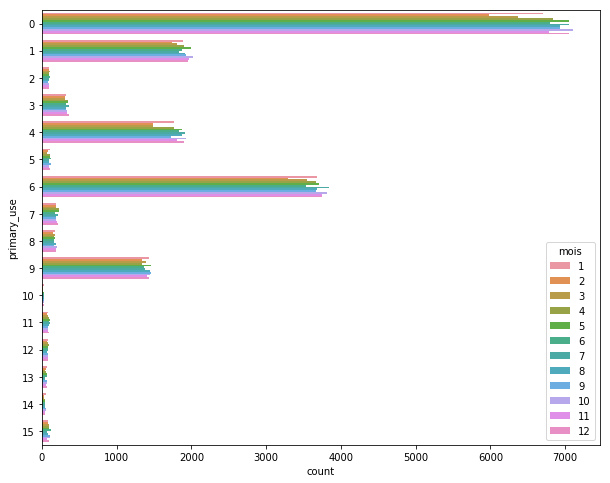

In [26]:
##############
#### Représentation de "indicator of the primary category of activities of the 
#### building" par mois
##############

fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(y='primary_use', data=df, hue='mois')

In [27]:
##############
#### Graphiques qui ne fonctionnent pas
##############

'''for bldg_id in [df['building_id']]:
    plt.figure(figsize=(16,5))
    tmp_df = df[df['building_id'] == bldg_id].copy()
    tmp_df.set_index(tmp_df["timestamp"], inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(16,5))
    tmp_df = df.set_index("timestamp", inplace=True)
    tmp_df.meter_reading.sum().plot()
    plt.title(f"Meter readings for building")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()
    
    from pandas import Grouper

groups = df['meter_reading'].groupby(Grouper(freq='M'))
months = concat([(x[1].values) for x in groups], axis=1)
months = df(mois)
months.columns = range(1,13)
months.boxplot()
pyplot.show()

df_tmpY = df.groupby('annee').count()
plt.plot(df_tmpY['meter_reading'])

df_tmp = df.groupby('mois').count()
plt.plot(df_tmp['meter_reading'])

df.plot(df['air_temperature'], figsize=(12,4))

sns.set()
df.resample('meter_reading').mean().plot(style=':')

df.set_index("timestamp", inplace=True)
df.resample('D').meter_reading.sum().plot()
'''

'for bldg_id in [df[\'building_id\']]:\n    plt.figure(figsize=(16,5))\n    tmp_df = df[df[\'building_id\'] == bldg_id].copy()\n    tmp_df.set_index(tmp_df["timestamp"], inplace=True)\n    tmp_df.resample("D").meter_reading.sum().plot()\n    plt.title(f"Meter readings for building #{bldg_id} ")\n    plt.xlabel("Sum of readings")\n    plt.tight_layout()\n    plt.show()\n    \n    plt.figure(figsize=(16,5))\n    tmp_df = df.set_index("timestamp", inplace=True)\n    tmp_df.meter_reading.sum().plot()\n    plt.title(f"Meter readings for building")\n    plt.xlabel("Sum of readings")\n    plt.tight_layout()\n    plt.show()\n    \n    from pandas import Grouper\n\ngroups = df[\'meter_reading\'].groupby(Grouper(freq=\'M\'))\nmonths = concat([(x[1].values) for x in groups], axis=1)\nmonths = df(mois)\nmonths.columns = range(1,13)\nmonths.boxplot()\npyplot.show()\n\ndf_tmpY = df.groupby(\'annee\').count()\nplt.plot(df_tmpY[\'meter_reading\'])\n\ndf_tmp = df.groupby(\'mois\').count()\nplt.plot(df_

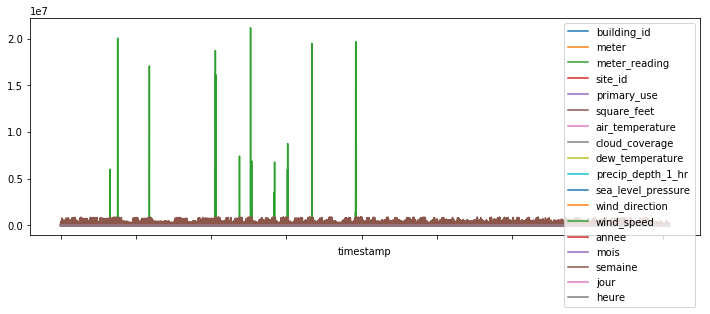

In [28]:
##############
#### Représentation de toutes les variables selon le temps
##############

# !!!! Attention long car toutes les valeurs de timestamp s'affichent !!!

df.set_index('timestamp', inplace=True) #le nouvel index correspond à timestamp ce qui permet de réaliser des graphiques temporels
df.plot(figsize=(12,4))

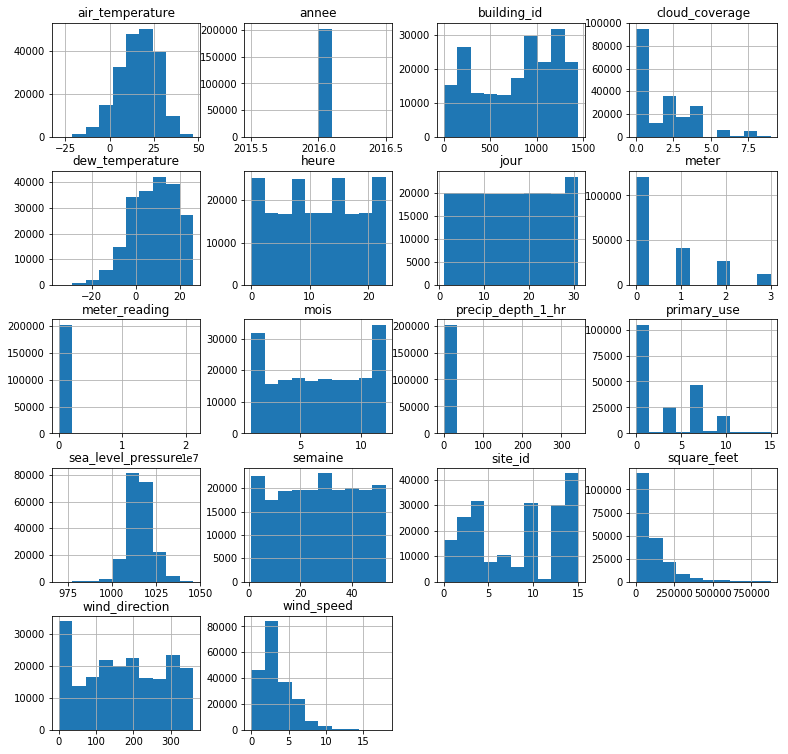

In [29]:
df.hist(figsize = (13,13))
plt.show()

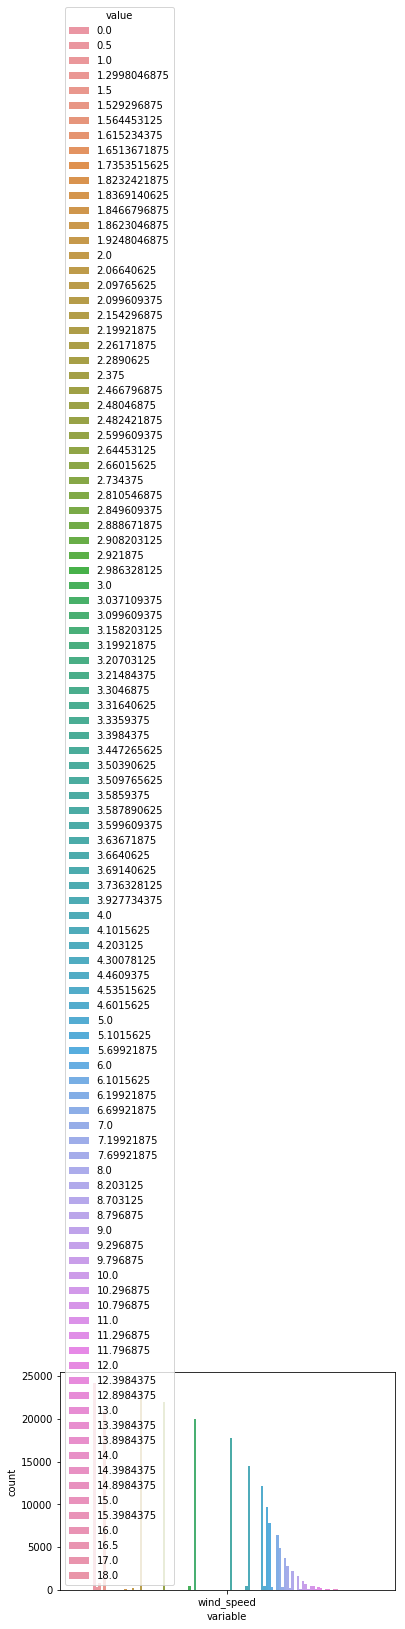

In [30]:
df_categorical = df.loc[:,['wind_speed']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));

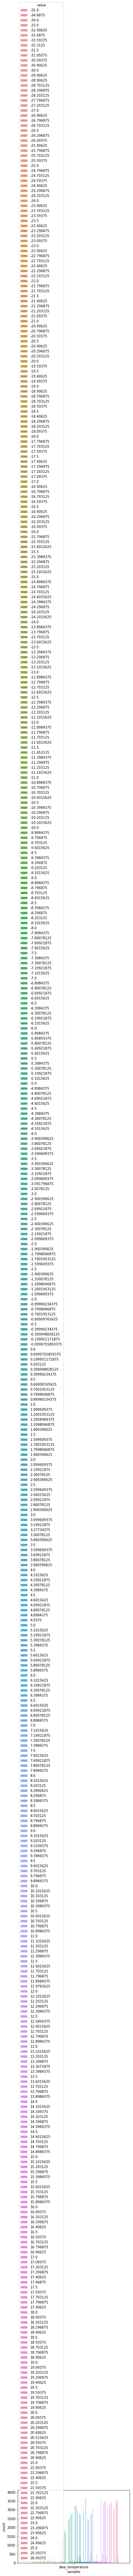

In [31]:
df_categorical = df.loc[:,['dew_temperature']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));

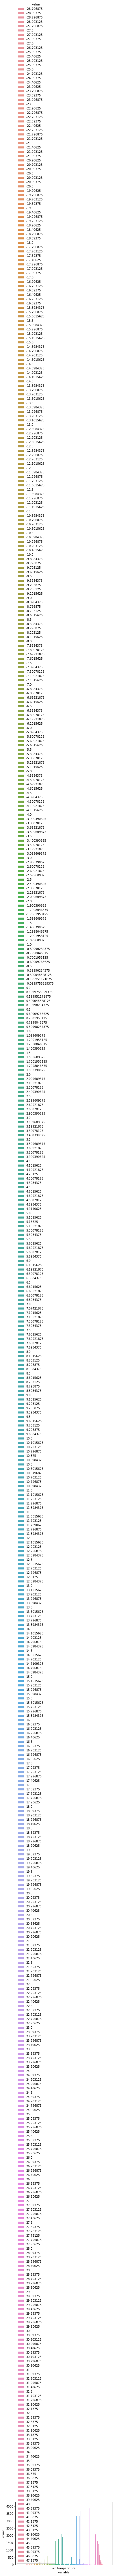

In [32]:
df_categorical = df.loc[:,['air_temperature']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical));

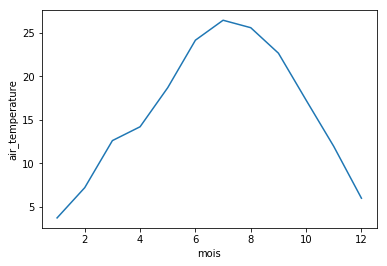

In [33]:
#Représentation de l'évolution des température par mois; on préfère le second graphique
#sous forme de ligne que le premier qui est un histogramme
'''
df.groupby('mois')['air_temperature'].mean().plot(kind='bar')
plt.ylabel('air_temperature')
plt.show()
'''
time_grp = df.groupby('mois')['air_temperature'].mean().reset_index()
sns.lineplot(x='mois', y='air_temperature', data=time_grp)


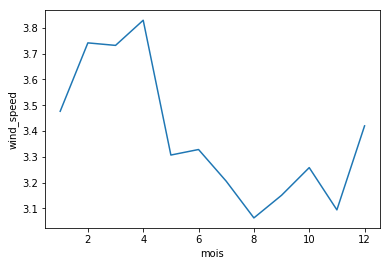

In [35]:
#Représentation de la vitesse du vent sur un an par mois

'''df.groupby('mois')['wind_speed'].mean().plot(kind='bar')
plt.ylabel('wind_speed')
plt.show()'''

time_grp = df.groupby('mois')['wind_speed'].mean().reset_index()
sns.lineplot(x='mois', y='wind_speed', data=time_grp)

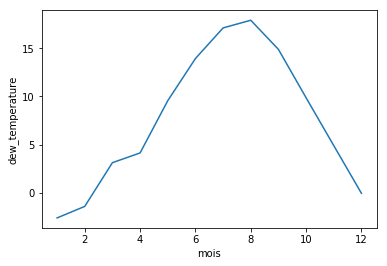

In [36]:
#représentation de la température de dew par mois sur un an

'''df.groupby('mois')['dew_temperature'].mean().plot(kind='bar')
plt.ylabel('dew_temperature')
plt.show()'''

time_grp = df.groupby('mois')['dew_temperature'].mean().reset_index()
sns.lineplot(x='mois', y='dew_temperature', data=time_grp)

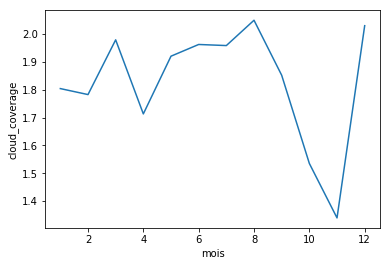

In [37]:
#représentation des nuages par mois pendant une annnée

'''df.groupby('mois')['cloud_coverage'].mean().plot(kind='bar')
plt.ylabel('cloud_coverage')
plt.show()'''

time_grp = df.groupby('mois')['cloud_coverage'].mean().reset_index()
sns.lineplot(x='mois', y='cloud_coverage', data=time_grp)

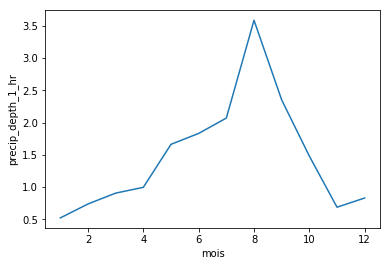

In [38]:
#Représentation des précipitations moyennes par heure par mois pendant une an

'''df.groupby('mois')['precip_depth_1_hr'].mean().plot(kind='bar')
plt.ylabel('air_temperature')
plt.show()'''

time_grp = df.groupby('mois')['precip_depth_1_hr'].mean().reset_index()
sns.lineplot(x='mois', y='precip_depth_1_hr', data=time_grp)

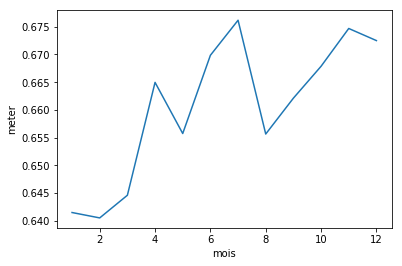

In [39]:
'''df.groupby('mois')['meter'].mean().plot(kind='bar')
plt.ylabel('meter')
plt.show()'''

time_grp = df.groupby('mois')['meter'].mean().reset_index()
sns.lineplot(x='mois', y='meter', data=time_grp)

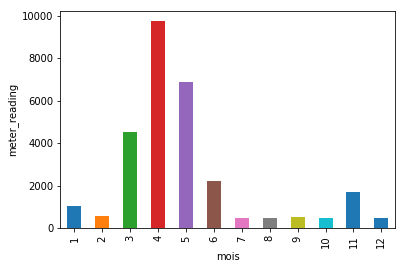

In [40]:
df.groupby('mois')['meter_reading'].mean().plot(kind='bar')
plt.ylabel('meter_reading')
plt.show()

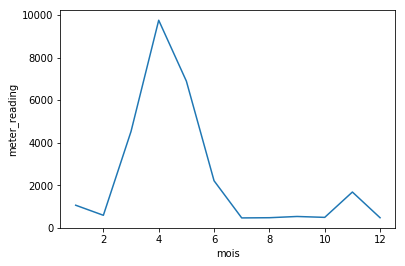

In [41]:
time_grp = df.groupby('mois')['meter_reading'].mean().reset_index()
sns.lineplot(x='mois', y='meter_reading', data=time_grp)

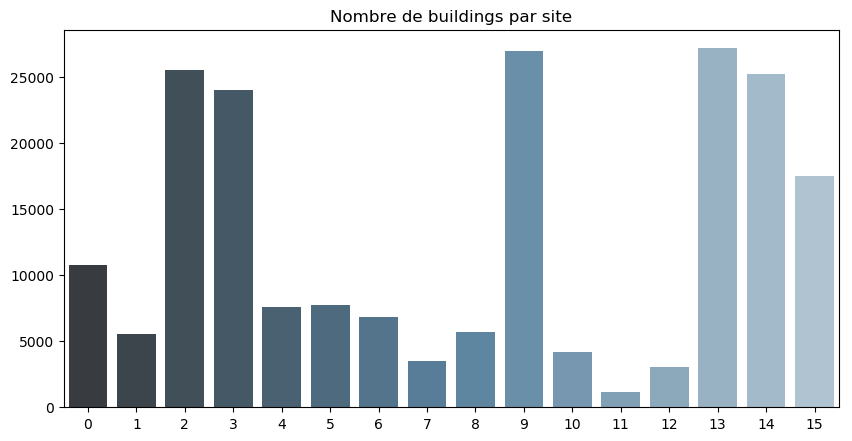

In [42]:
##############
#### Building par site
##############

df_build_site = df.site_id.value_counts()
fig, axes = plt.subplots(1,1,figsize=(10, 5), dpi=100)
sns.barplot(x=df_build_site.index,
           y=df_build_site.values,
           palette = 'Blues_d',
           saturation=.5)
axes.set_title('Nombre de buildings par site')
del df_build_site

# Split des données Entrainement/Test

In [31]:
##############
#### Suppression des bases initiales
##############

del train
del weather_train
del building_meta

In [32]:
##############
#### Création de la variable cible et des variables explicatioves
#### Split en App/Test
##############


X=df.drop(columns=["meter_reading","timestamp"])
y=np.log1p(df["meter_reading"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


del X
del y
del df

gc.collect()

2484

# Modèle de Prédiction

## Random Forest

In [45]:
##############
#### Création de forets dans le but de réduire la demande mémoire
##############


from sklearn.ensemble import forest
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))
set_rf_samples(130000)


def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [46]:
model = RandomForestRegressor(n_estimators=60,
                              random_state=0,
                              n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [47]:
y_pred=model.predict(X_test)
print('The rmse of prediction is:', mean_squared_log_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.3091833139544041


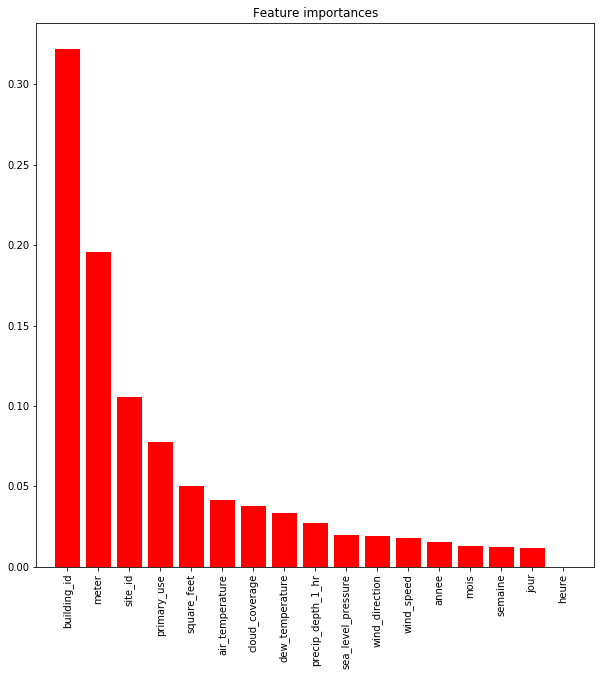

In [48]:
##############
#### Importance des variables dans la foret d'arbre
##############

feature_names = X_train.columns
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [49]:
##############
#### Kfold pour la réglage des parametres de la random forest
#### Attention beaucoup de calcul
##############

from sklearn.model_selection import KFold

kf = KFold(n_splits= 2,shuffle=True,random_state=42)

n_estimators = [100, 150]

moyenne_erreur_K_fold = []
ecart_type_erreur_K_fold =[]

for i in range(0,len(n_estimators)):
    erreur_fold = []
    for train_index, test_index in kf.split(X_train):
        X_train_K_fold, X_test_K_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_K_fold, y_test_K_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        model_K_fold = RandomForestRegressor(n_estimators=n_estimators[i],
                                             random_state=0,
                                             n_jobs=-1,
                                             )
        model_K_fold.fit(X_train_K_fold,y_train_K_fold)
        y_pred_K_fold = model_K_fold.predict(X_test_K_fold)
        erreur = mean_squared_error(y_test_K_fold, y_pred_K_fold) ** 0.5
        erreur_fold.append(erreur)
    moyenne_erreur_K_fold.append(np.mean(erreur))
    ecart_type_erreur_K_fold.append(np.std(erreur_fold))

del X_train_K_fold
del X_test_K_fold
del y_train_K_fold
del y_test_K_fold

gc.collect()


3599

In [50]:
print(moyenne_erreur_K_fold)
print(ecart_type_erreur_K_fold)

[0.9877927801809367, 0.9856083877576384]
[0.011957971566831205, 0.01162843414328485]


## Kfold pour le réglage des paramétres de la random forest
K fold a 3 partie pour éviter trop de calcul  
Réglage effectué:
- n_estimators : [50,100,150,200] 
    - rmsle respective : [2.968147610655667, 2.9671450330825153, 2.9666543089927586, 2.966109024713737]
    - Pas d'amélioration significative, donc on peut choisir un n_estimators de 75
- max_depth : [25, 50, 100, 150, 200] (n_estimators fixé à 75)
    - rmsle respective : [2.9662009028792156, 2.967497273677587, 2.967527376580337, 2.967527376580337, 2.967527376580337]
    - Augmentation de l'erreur donc on retente avec un nouvelle intervalle
- max_depth : [5,10,15,20,25] (n_estimators fixé à 75)
    - rmsle respective : [2.800616598084297, 2.8614102668615957, 2.922111845686289, 2.9581722179653602, 2.9662009028792156]
    - Tjrs une augmentation de l'erreur donc on va choisir de ne pas mettre de limite au max_depth
- min_samples_split = [5,10,15,20,25]
    - [2.9673285523485937, 2.967651845164756, 2.966488144150637, 2.9648115928331764, 2.9625328461344123]


In [51]:
##############
#### Reset des forêts
##############

reset_rf_samples()


## KNN

In [52]:
from sklearn.neighbors import KNeighborsRegressor

In [53]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
k_range = [5, 10, 15, 20]
erreur_knn = []
for i in range(0,len(k_range)):
    knn = KNeighborsRegressor(n_neighbors=k_range[i],n_jobs=-1, weights='distance')
    knn.fit(X_train_knn,y_train_knn)
    y_pred = knn.predict(X_test_knn)
    erreur = mean_squared_error(y_test_knn, y_pred)**0.5
    erreur_knn.append(erreur)

del X_train_knn
del X_test_knn
del y_test_knn
del y_train_knn
del y_pred

gc.collect()

31

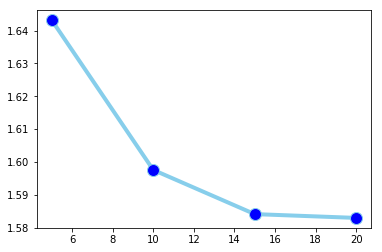

In [54]:
plt.plot( k_range,erreur_knn , marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)

## Gradient Boosting avec LightGBM

In [33]:
##############
#### Création des DataSets de LightGBM & des paramètres de ses datasets
##############

categorical_features = ["building_id", "site_id", "meter", "primary_use"]

lgb_train = lgb.Dataset(X_train, 
                        label=y_train,
                        categorical_feature=categorical_features,
                        free_raw_data=False)

lgb_eval = lgb.Dataset(X_test, 
                       label=y_test,
                       categorical_feature=categorical_features,
                       free_raw_data=False)


In [34]:
##############
#### Paramètre du gradient boosting
##############

params_lgb = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1000,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

In [35]:
##############
#### Entrainement du modele
##############

model_lgb = lgb.train(params_lgb, 
                train_set=lgb_train, 
                num_boost_round=1000, 
                valid_sets=[lgb_train,lgb_eval], 
                verbose_eval=100, 
                early_stopping_rounds=50)

D:\Programme\Anaconda\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.69294	valid_1's rmse: 0.696687
[200]	training's rmse: 0.599038	valid_1's rmse: 0.607221
[300]	training's rmse: 0.565501	valid_1's rmse: 0.577908
[400]	training's rmse: 0.542954	valid_1's rmse: 0.559172
[500]	training's rmse: 0.527215	valid_1's rmse: 0.54696
[600]	training's rmse: 0.513622	valid_1's rmse: 0.536431
[700]	training's rmse: 0.50245	valid_1's rmse: 0.528231
[800]	training's rmse: 0.492993	valid_1's rmse: 0.52147
[900]	training's rmse: 0.485573	valid_1's rmse: 0.516577
[1000]	training's rmse: 0.477718	valid_1's rmse: 0.511591
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.477718	valid_1's rmse: 0.511591


In [37]:
model_lgb.save_model('model.txt')